In [ ]:
import random
import pickle
import heapq

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer

import re
from nltk.tokenize import word_tokenize
import json

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Activation
from tensorflow.keras.optimizers import RMSprop

from transformers import AutoTokenizer
from collections import Counter

In [ ]:
text_df = pd.read_csv("/content/trashup_craft_idea_dataset.csv")
text_df.head()

,Title,Text,Label
0,Rak Buku Kecil,"Daripada dibuang, kardus bisa dikreasikan menj...",Kertas
1,Ayunan Anak,"Daripada dibuang, ban bisa dikreasikan menjadi...",Karet
2,Lampu Hias,Mari mengubah botol plastik menjadi sesuatu ya...,Plastik
3,Hiasan Mozaik,Ingin mendaur ulang pecahan kaca? Anda bisa me...,Kaca
4,Hiasan Dinding,Berikut ide kreatif untuk memanfaatkan kain pe...,Tekstil


In [ ]:
text_df_copy = text_df.copy()

# 1. Text Cleaning yang lebih komprehensif
def clean_text(text):
    # Lowercase
    text = text.lower()

    # Standardisasi angka
    number_mapping = {
        '1': 'pertama',
        '2': 'kedua',
        '3': 'ketiga',
        '4': 'keempat',
        '5': 'kelima',
        '6': 'keenam',
        '7': 'ketujuh',
        '8': 'kedelapan',
        '9': 'kesembilan',
        '10': 'kesepuluh'
    }

    for num, word in number_mapping.items():
        text = text.replace(num, word)

    # Hapus karakter yang tidak diperlukan
    text = re.sub(r'[^\w\s\.]', ' ', text)

    # Standardisasi spasi
    text = ' '.join(text.split())

    # Tambahkan spasi setelah titik untuk memisahkan kalimat
    text = re.sub(r'\.(?! )', '. ', text)

    return text

# 2. Preprocessing DataFrame
def preprocess_dataframe(df):
    df_copy = df.copy()
    df_copy['Text'] = df_copy['Text'].apply(clean_text)
    return df_copy

# 3. Tokenisasi yang lebih baik
def prepare_sequences(text, tokenizer, seq_length=10, vocab_size=10000):
    # Tokenisasi dengan IndoBERT
    tokens = tokenizer.tokenize(text)

    # Filter token
    tokens = [token for token in tokens if (
        token.isalpha() and  # Hanya kata
        len(token) > 1 and   # Minimal 2 karakter
        not token.startswith('##')  # Bukan subword
    )]

    # Buat vocabulary
    token_counts = Counter(tokens)
    most_common_tokens = ['<PAD>', '<UNK>', '<START>', '<END>'] + [
        token for token, _ in token_counts.most_common(vocab_size-4)
    ]
    token_to_idx = {token: idx for idx, token in enumerate(most_common_tokens)}

    # Persiapkan sequences
    sequences = []
    next_tokens = []

    for i in range(len(tokens) - seq_length):
        seq = tokens[i:i + seq_length]
        next_tok = tokens[i + seq_length]

        # Skip jika ada token yang tidak dalam vocabulary
        if all(token in token_to_idx for token in seq + [next_tok]):
            sequences.append([token_to_idx[token] for token in seq])
            next_tokens.append(token_to_idx[next_tok])

    return np.array(sequences), np.array(next_tokens), token_to_idx, most_common_tokens

# Implementasi
text_df_processed = preprocess_dataframe(text_df_copy)
joined_text = " ".join(text_df_processed.Text.values)

# Gunakan maksimal 1M karakter pertama
partial_text = joined_text[:1000000]

# Siapkan tokenizer
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
seq_length = 10
vocab_size=10000

# Buat sequences
X, y, token_to_idx, vocab = prepare_sequences(
    partial_text,
    tokenizer,
    seq_length=seq_length,
    vocab_size=vocab_size
)

tokens = tokenizer.tokenize(partial_text)

# Filter token
tokens = [token for token in tokens if (
    token.isalpha() and  # Hanya kata
    len(token) > 1 and   # Minimal 2 karakter
    not token.startswith('##')  # Bukan subword
)]

# Buat vocabulary
token_counts = Counter(tokens)

most_common_tokens = ['<PAD>', '<UNK>', '<START>', '<END>'] + [
        token for token, _ in token_counts.most_common(vocab_size-4)
]

# Simpan vocabulary untuk generate text nanti
vocab_size = len(vocab)
unique_token_index = {idx: token for token, idx in token_to_idx.items()}

# Simpan untuk penggunaan nanti
np.save('X_processed.npy', X)
np.save('y_processed.npy', y)

with open('vocab.json', 'w') as f:
    json.dump({'token_to_idx': token_to_idx, 'vocab': vocab}, f)

print(f"Data shape: X: {X.shape}, y: {y.shape}")
print(f"Vocabulary size: {vocab_size}")

Data shape: X: (139674, 10), y: (139674,)
Vocabulary size: 162


In [ ]:
def inspect_sequence(X, y, idx_to_token, num_samples=5):
    for i in range(num_samples):
        idx = np.random.randint(len(X))
        input_seq = ' '.join([idx_to_token[idx] for idx in X[idx]])
        next_token = idx_to_token[y[idx]]
        print(f"\nInput sequence {i+1}: {input_seq}")
        print(f"Next token: {next_token}")

inspect_sequence(X, y, idx_to_token)


Input sequence 1: tempat sampah unik ayo dicoba mari mengubah pecahan kaca menjadi
Next token: sesuatu

Input sequence 2: sesuatu yang bernilai dengan membuat tas kecil persiapkan terlebih dahulu
Next token: kain

Input sequence 3: proses pembuatan bisa dilakukan dengan cara berikut tahap pertama potong
Next token: kantong

Input sequence 4: daripada dibuang kain perc bisa dik menjadi boneka mini yang
Next token: cantik

Input sequence 5: lengkap pembuatannya pertama bersihkan mainan bekas kedua gunakan kapas ketiga
Next token: paku


In [ ]:
# text_df_copy.loc[:, 'Text'] = text_df_copy['Text'] = (
#     text_df_copy['Text']
#     .str.replace('!', ' ', regex=False)
#     .str.replace('?', ' ', regex=False)
#     .str.replace('(', '', regex=False)
#     .str.replace(')', '.', regex=False)
#     .str.replace('-', ' ', regex=False)
#     .str.replace(':', '', regex=False)
#     .str.replace('.', '', regex=False)
#     .str.replace('1', 'pertama', regex=False)
#     .str.replace('2', 'kedua', regex=False)
#     .str.replace('3', 'tiga', regex=False)
#     .str.replace('4', 'empat', regex=False)
#     .str.replace('5', 'lima', regex=False)
# )
# text_df_copy.values

In [ ]:
# text = list(text_df_copy.Text.values)
# joined_text = " ".join(text)

# with open("joined_text.txt", "w", encoding="utf-8") as f:
#     f.write(joined_text)

In [ ]:
# partial_text = joined_text[:1000000]
# partial_text

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

# tokens = [token for token in tokenizer.tokenize(partial_text.lower()) if token.isalpha()]

In [ ]:
# token_counts = Counter(tokens)
# most_common_tokens = [token for token, _ in token_counts.most_common(10000)]
# unique_token_index = {token: index for index, token in enumerate(most_common_tokens)}

In [ ]:
# n_words = 10
# input_words = []
# next_word = []

# for i in range(len(tokens) - n_words):
#     input_words.append(tokens[i:i + n_words])
#     next_word.append(tokens[i + n_words])

In [ ]:
# # Asumsi bentuk data: X.shape = (batch_size, seq_length, feature_size)

# X = np.zeros((len(input_words), seq_length), dtype=int)
# y = np.zeros((len(next_word),), dtype=int)

# for i, words in enumerate(input_words):
#     for j, word in enumerate(words):
#         X[i, j] = unique_token_index[word]  # Gunakan indeks token, bukan one-hot
#     y[i] = unique_token_index[next_word[i]]  # Output target juga dalam bentuk indeks

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Activation, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def build_craft_model_v2(seq_length, vocab_size):
    model = Sequential([
        # Embedding layer
        Embedding(input_dim=vocab_size, output_dim=128, input_length=seq_length),

        # LSTM layers
        Bidirectional(LSTM(256, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(128)),
        Dropout(0.2),

        # Dense layers untuk output
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(vocab_size, activation='softmax')  # Output layer
    ])

    # Compile model
    # Ubah loss function pada model
    model.compile(
        loss=SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        metrics=['accuracy']
    )
    return model

# Fungsi untuk training
def train_craft_model(model, X, y, epochs=12, batch_size=64):
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    checkpoint = ModelCheckpoint(
        'best_trashup_model.keras',
        monitor='val_accuracy',
        save_best_only=True
    )

    # Training
    history = model.fit(
        X, y,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )

    return history

# Bangun model baru
model = build_craft_model_v2(seq_length, vocab_size)


# Konversi y menjadi one-hot encoding
y_one_hot = to_categorical(y, num_classes=vocab_size)

# Training
history = train_craft_model(model, X, y)

Epoch 1/12
1773/1773 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.3319 - loss: 2.7227 - val_accuracy: 0.6684 - val_loss: 0.9034
Epoch 2/12
1773/1773 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.6745 - loss: 0.9081 - val_accuracy: 0.6939 - val_loss: 0.8109
Epoch 3/12
1773/1773 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.7014 - loss: 0.7989 - val_accuracy: 0.7145 - val_loss: 0.7329
Epoch 4/12
1773/1773 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.7085 - loss: 0.7572 - val_accuracy: 0.7123 - val_loss: 0.7299
Epoch 5/12
1773/1773 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.7172 - loss: 0.7254 - val_accuracy: 0.7134 - val_loss: 0.7325
Epoch 6/12
1773/1773 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.7234 - loss: 0.7041 - val_accuracy: 0.7307 - val_loss: 0.6853
Epoch 7/12
1773/1773 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.7326 - loss: 0.6756 - val_accuracy: 0.7406 - val_loss: 0.6514
Epoch 8/12
1773/1773 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.7432 -

In [ ]:
# model = Sequential()
# model.add(LSTM(128, input_shape=(n_words, len(most_common_tokens)), return_sequences=True))
# model.add(LSTM(128))
# model.add(Dense(len(most_common_tokens)))
# model.add(Activation("softmax"))

In [ ]:
# optimizer = RMSprop(learning_rate=0.01)
# model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# history = model.fit(X, y, batch_size=128, epochs=10, shuffle=True).history

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LayerNormalization, MultiHeadAttention, Dropout, Dense
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class TransformerModel(Model):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, max_length):
        super(TransformerModel, self).__init__()
        self.embedding = Embedding(vocab_size, embed_dim, input_length=max_length)
        self.pos_encoding = self.positional_encoding(max_length, embed_dim)

        self.encoder_layers = [
            TransformerEncoderLayer(embed_dim, num_heads, ff_dim)
            for _ in range(num_layers)
        ]

        self.final_layer = Dense(embed_dim)
        self.decoder = Dense(vocab_size, activation='softmax')

    def call(self, inputs):
        # Add batch dimension to positional encoding
        pos_encoding = tf.broadcast_to(self.pos_encoding, [tf.shape(inputs)[0], tf.shape(self.pos_encoding)[1], tf.shape(self.pos_encoding)[2]])

        x = self.embedding(inputs)
        x += pos_encoding

        for layer in self.encoder_layers:
            x = layer(x)

        # Global average pooling
        x = tf.reduce_mean(x, axis=1)

        x = self.final_layer(x)
        return self.decoder(x)

    def positional_encoding(self, max_length, embed_dim):
        positions = tf.range(start=0, limit=max_length, delta=1.0)[:, tf.newaxis]
        dimensions = tf.range(start=0, limit=embed_dim, delta=2.0) / tf.cast(embed_dim, tf.float32)
        angle_rates = tf.math.exp(-tf.math.log(10000.0) * dimensions)
        angle_rads = positions * angle_rates

        pos_encoding = tf.concat(
            [tf.sin(angle_rads), tf.cos(angle_rads)],
            axis=-1
        )

        return tf.expand_dims(pos_encoding, axis=0)

class TransformerEncoderLayer(Model):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super(TransformerEncoderLayer, self).__init__()
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(0.1)

    def call(self, inputs):
        attn_output = self.attn(inputs, inputs)
        attn_output = self.dropout(attn_output)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output)
        return self.layernorm2(out1 + ffn_output)

# Inisialisasi model
model = TransformerModel(
    vocab_size=vocab_size,
    embed_dim=256,
    num_heads=8,
    ff_dim=512,
    num_layers=6,
    max_length=seq_length
)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_transformer_model.keras',
    monitor='val_accuracy',
    save_best_only=True
)

# Training
history = model.fit(
    X, y,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 104s 17ms/step - accuracy: 0.1764 - loss: 3.8272 - val_accuracy: 0.6790 - val_loss: 0.8889
Epoch 2/15
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.6856 - loss: 0.8675 - val_accuracy: 0.7019 - val_loss: 0.8001
Epoch 3/15
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.7040 - loss: 0.7945 - val_accuracy: 0.7109 - val_loss: 0.7558
Epoch 4/15
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.7169 - loss: 0.7411 - val_accuracy: 0.7279 - val_loss: 0.7028
Epoch 5/15
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.7340 - loss: 0.6882 - val_accuracy: 0.7283 - val_loss: 0.7233
Epoch 6/15
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.7375 - loss: 0.6744 - val_accuracy: 0.7435 - val_loss: 0.6533
Epoch 7/15
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.7436 - loss: 0.6526 - val_accuracy: 0.7447 - val_loss: 0.6530
Epoch 8/15
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.7439 - loss:

In [ ]:
model.save("trashup_trans_model.h5")
with open("history2.p", "wb") as f:
    pickle.dump(history, f)

In [ ]:
model = load_model("trashup_trans_model.h5")
history = pickle.load(open("history2.p", "rb"))

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 19 variables whereas the saved optimizer has 36 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


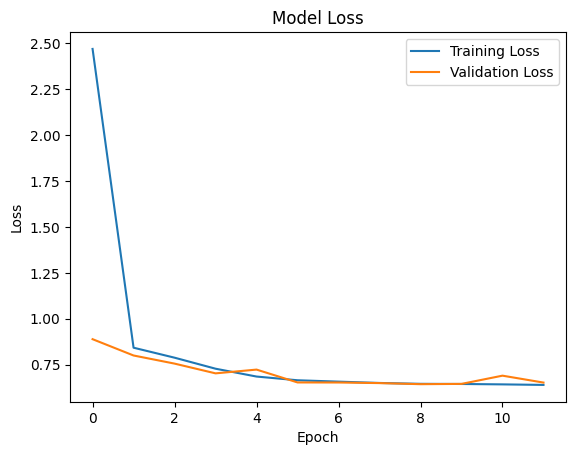

In [ ]:
# Untuk melihat hasil training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def generate_text(model, seed_text, max_tokens=50):
    # Tokenisasi seed text
    input_sequence = [token_to_idx.get(token, 0)
                     for token in tokenizer.tokenize(seed_text.lower())
                     if token.isalpha()]

    # Pad sequence jika kurang dari seq_length
    if len(input_sequence) < seq_length:
        input_sequence = [0] * (seq_length - len(input_sequence)) + input_sequence
    else:
        input_sequence = input_sequence[-seq_length:]

    input_sequence = np.array([input_sequence])  # Add batch dimension

    generated_text = seed_text

    # Generate text
    for _ in range(max_tokens):
        predictions = model.predict(input_sequence, verbose=0)
        predicted_token_idx = np.argmax(predictions[0])

        # Convert index to token
        predicted_token = most_common_tokens[predicted_token_idx]
        generated_text += " " + predicted_token

        # Update input sequence
        input_sequence = np.roll(input_sequence, -1, axis=1)
        input_sequence[0, -1] = predicted_token_idx

    return generated_text

# Cara penggunaan:
seed_text = "punya botol plastik yang tidak terpakai"
generated = generate_text(
    model=model,           # Model Transformer yang sudah di-training
    seed_text=seed_text,   # Teks awal
    max_tokens=50          # Jumlah token yang ingin digenerate
)
print(generated)

punya botol plastik yang tidak terpakai yuk sulap menjadi lampu hias untuk membuatnya siapkan bahan bahan berikut kayu dan gunting proses pembuatan bisa dilakukan dengan cara berikut pertama gabung kardus bekas dengan kayu kedua lilin ketiga bentuk menjadi hiasan dinding mudah bukan sekarang kardus anda sudah menjadi hiasan dinding yang bermanfaat punya kardus yang tidak terpakai


In [ ]:
# Contoh untuk teks pendek
generated_short = generate_text(model, "membuat kerajinan", max_tokens=20)

# Contoh untuk teks panjang
generated_long = generate_text(model, "cara membuat kerajinan dari botol bekas", max_tokens=100)

# Contoh dengan prompt yang lebih spesifik
generated_specific = generate_text(
    model,
    "langkah pertama dalam membuat pot bunga dari botol plastik adalah",
    max_tokens=50
)

In [ ]:
generated_long

'cara membuat kerajinan dari botol bekas selamat berkreasi punya kardus yang tidak terpakai yuk sulap menjadi hiasan dinding untuk membuatnya siapkan bahan bahan berikut kayu dan gunting proses pembuatan bisa dilakukan dengan cara berikut pertama gabung kardus bekas dengan kayu kedua lilin ketiga bentuk menjadi hiasan dinding mudah bukan sekarang kardus anda sudah menjadi hiasan dinding yang bermanfaat punya kardus yang tidak terpakai yuk sulap menjadi hiasan dinding untuk membuatnya siapkan bahan bahan berikut kayu dan gunting proses pembuatan bisa dilakukan dengan cara berikut pertama gabung kardus bekas dengan kayu kedua lilin ketiga bentuk menjadi hiasan dinding mudah bukan sekarang kardus anda sudah menjadi hiasan dinding'

In [ ]:
def generate_text_with_temp(model, seed_text, max_tokens=50, temperature=0.7):
    # ... kode sama seperti sebelumnya sampai predictions ...
    # Tokenisasi seed text
    input_sequence = [token_to_idx.get(token, 0)
                     for token in tokenizer.tokenize(seed_text.lower())
                     if token.isalpha()]

    # Pad sequence jika kurang dari seq_length
    if len(input_sequence) < seq_length:
        input_sequence = [0] * (seq_length - len(input_sequence)) + input_sequence
    else:
        input_sequence = input_sequence[-seq_length:]

    input_sequence = np.array([input_sequence])  # Add batch dimension

    generated_text = seed_text

    predictions = model.predict(input_sequence, verbose=0)
    # Apply temperature
    predictions = predictions[0] / temperature
    predictions = np.exp(predictions) / np.sum(np.exp(predictions))
    predicted_token_idx = np.random.choice(len(predictions), p=predictions)

    # Convert index to token
    predicted_token = most_common_tokens[predicted_token_idx]
    generated_text += " " + predicted_token

    # Update input sequence
    input_sequence = np.roll(input_sequence, -1, axis=1)
    input_sequence[0, -1] = predicted_token_idx

    return generated_text

# Penggunaan dengan temperature berbeda
# Temperature rendah = lebih konsisten
generated_safe = generate_text_with_temp(model, seed_text, temperature=0.5)

# Temperature tinggi = lebih kreatif
generated_creative = generate_text_with_temp(model, seed_text, temperature=1.0)

In [ ]:
generated_creative

'punya botol plastik yang tidak terpakai ide'

In [ ]:
# def generate_text(model, seed_text, tokenizer, max_length=50):
#     input_sequence = tokenizer.texts_to_sequences([seed_text])[0]
#     input_sequence = tf.keras.preprocessing.sequence.pad_sequences(
#         [input_sequence], maxlen=seq_length, padding='pre'
#     )

#     generated_text = seed_text

#     for _ in range(max_length):
#         predictions = model.predict(input_sequence, verbose=0)
#         predicted_token = tf.argmax(predictions[0]).numpy()

#         # Convert token to word
#         predicted_word = ""
#         for word, index in unique_token_index.items():
#             if index == predicted_token:
#                 predicted_word = word
#                 break

#         generated_text += " " + predicted_word

#         # Update input sequence
#         input_sequence = input_sequence[:, 1:]
#         input_sequence = tf.keras.preprocessing.sequence.pad_sequences(
#             [[*input_sequence[0], predicted_token]],
#             maxlen=seq_length,
#             padding='pre'
#         )

#     return generated_text

In [ ]:
# def predict_next_word(input_text, n_best):
#     # Preprocess input text
#     input_text = input_text.lower()
#     tokenized = input_text.split()

#     # Konversi input text ke indeks token
#     X = np.zeros((1, n_words), dtype=int)
#     for i, word in enumerate(tokenized):
#         if i < n_words:  # Pastikan tidak melebihi panjang sequence
#             if word in unique_token_index:
#                 X[0, i] = unique_token_index[word]
#             else:
#                 X[0, i] = unique_token_index['<unk>']  # Gunakan token UNK jika tidak dikenal

#     # Prediksi dengan model
#     predictions = model.predict(X)[0]

#     # Ambil n prediksi terbaik
#     best_indices = np.argsort(predictions)[-n_best:][::-1]  # Urutkan dari nilai tertinggi
#     best_words = [most_common_tokens[idx] for idx in best_indices]

#     return best_words


In [ ]:
# possible = predict_next_word("Punya botol plastik yang tidak terpakai", 5)
# possible

In [ ]:
# def generate_text(model, input_sequence, n_words):
#     for _ in range(n_words):
#         predicted_probs = model.predict(input_sequence)
#         predicted_token = tf.argmax(predicted_probs, axis=-1)
#         input_sequence = tf.concat([input_sequence, predicted_token], axis=-1)
#     return tokenizer.decode(input_sequence[0].numpy())

In [ ]:
# def generate_text(input_text, n_words_to_generate, creativity):
#     """
#     Fungsi untuk menghasilkan teks berdasarkan input awal.
#     Args:
#         input_text (str): Teks awal untuk memulai generasi.
#         n_words_to_generate (int): Jumlah kata yang akan dihasilkan.
#         creativity (int): Jumlah opsi kata terbaik yang dipilih secara acak.

#     Returns:
#         str: Teks yang dihasilkan.
#     """
#     # Tokenisasi teks input
#     word_sequence = input_text.lower().split()

#     for _ in range(n_words_to_generate):
#         # Ambil sub_sequence dengan panjang maksimum (n_words)
#         sub_sequence = word_sequence[-n_words:] if len(word_sequence) >= n_words else word_sequence

#         # Prediksi kata berikutnya
#         try:
#             next_word_options = predict_next_word(" ".join(sub_sequence), creativity)
#             # Pilih kata berikutnya secara acak dari opsi terbaik
#             next_word = random.choice(next_word_options)
#         except Exception as e:
#             print(f"Error during prediction: {e}")
#             # Jika terjadi error, pilih kata acak dari kosakata
#             next_word = random.choice(list(unique_token_index.keys()))

#         # Tambahkan kata berikutnya ke sequence
#         word_sequence.append(next_word)

#     return " ".join(word_sequence)


In [ ]:
# generated_text = generate_text("punya botol plastik yang tidak terpakai", 100, 10)

In [ ]:
model.save("/content/trashup_trans_model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.allow_custom_ops = True
tflite_model = converter.convert()

with open("/content/trashup_transformer_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Konversi ke TFLite selesai!")

Saved artifact at '/tmp/tmpmnzxra9i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 162), dtype=tf.float32, name=None)
Captures:
  138666411527504: TensorSpec(shape=(1, 10, 256), dtype=tf.float32, name=None)
  138666401417872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666401420864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666401428608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666401427904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666401430896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666401422976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666401422096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666401423328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666401429136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666401429312: Tenso